# Import do arquivo e transformações

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

filterwarnings('ignore')
os.chdir(r"/Users/bentofh/Documents/GitHub/Store Sales")

In [172]:
df = pd.read_csv('train.csv')

In [173]:
# Transformar a coluna de data em datetime
df['date'] = pd.to_datetime(df['date'])

# Remover 2017-08 da análise pois não é um mês completo
mask_1708 = df['date'].dt.strftime('%Y-%m').str.startswith('2017-08')
df = df[~mask_1708]

# Coluna de ano, trimestre e mês
df['ano'] = df['date'].dt.year 
df['mes'] = df['date'].dt.month 
df['trimestre'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str)).dt.to_period('Q')

# Adicionando id por grupo de ano e mês
df['yyyy_mm'] = df['ano'].astype(str) + '-' + df['mes'].astype(str)

# Transformando coluna string em int 'family'
mapeamento_valores_family = {}

for i, valor in enumerate(df['family'].unique()):
    mapeamento_valores_family[valor] = i

df['ft_family'] = df['family'].map(mapeamento_valores_family)

# Transformando coluna string em int 'trimestre'
mapeamento_valores_trimestre = {}

for i, valor in enumerate(df['trimestre'].unique()):
    mapeamento_valores_trimestre[valor] = i

df['trimestre_id'] = df['trimestre'].map(mapeamento_valores_trimestre)

# Range de datas
print("Data mínima:", df['date'].min())
print("Data máxima:", df['date'].max())

Data mínima: 2013-01-01 00:00:00
Data máxima: 2017-07-31 00:00:00


In [174]:
# plt.figure(figsize = (16, 9))
# sns.lineplot(x = df.date, y = df.sales)
# plt.show()

In [175]:
# Renomear colunas para identificar as features ft_ e target tg_
renomear_colunas = {
    'store_nbr': 'ft_store',
    'onpromotion': 'ft_onpromotion',
    'ano': 'ft_ano',
    'mes': 'ft_mes',
    'sales': 'tg_sales'
}

df.rename(columns=renomear_colunas, inplace=True)

df.head()

,id,date,ft_store,family,tg_sales,ft_onpromotion,ft_ano,ft_mes,trimestre,yyyy_mm,ft_family,trimestre_id
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,2013Q1,2013-1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,2013Q1,2013-1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,2013Q1,2013-1,2,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,2013Q1,2013-1,3,0
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,2013Q1,2013-1,4,0


In [176]:
df['trimestre'].unique()

<PeriodArray>
['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
 '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
 '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3']
Length: 19, dtype: period[Q-DEC]

# Separando df de Teste

In [177]:
# Vamos separar o último trimestre para teste
df_teste = df[df['trimestre'] == '2017Q3']
df_teste.shape

(55242, 12)

In [178]:
# Separando os dados que sobraram para tv (treino e validação)
df_tv = df[df['trimestre'] != '2017Q3']
df_tv.shape

(2918916, 12)

In [179]:
X_test = df_teste.filter(regex = r'ft_')
y_test = df_teste['tg_sales']

modelo = LGBMRegressor( max_depth = 5, 
                        num_leaves = 32, 
                        verbose = -1, 
                        learning_rate = 0.01, 
                        n_estimators = 1000, 
                        colsample_bytree = 0.1, 
                        random_state = 0)
modelo.fit(X_test, y_test)

predictions = pd.Series(modelo.predict(X_test))

ranked_predictions = predictions.rank(pct = True, method = 'first')
correlation = np.corrcoef(y_test, ranked_predictions)[0, 1]
valor_teste_prd = correlation

# Testes Fernando

In [180]:
df_teste.head()

,id,date,ft_store,family,tg_sales,ft_onpromotion,ft_ano,ft_mes,trimestre,yyyy_mm,ft_family,trimestre_id
2918916,2918916,2017-07-01,1,AUTOMOTIVE,7.0,0,2017,7,2017Q3,2017-7,0,18
2918917,2918917,2017-07-01,1,BABY CARE,0.0,0,2017,7,2017Q3,2017-7,1,18
2918918,2918918,2017-07-01,1,BEAUTY,7.0,1,2017,7,2017Q3,2017-7,2,18
2918919,2918919,2017-07-01,1,BEVERAGES,2596.0,27,2017,7,2017Q3,2017-7,3,18
2918920,2918920,2017-07-01,1,BOOKS,0.0,0,2017,7,2017Q3,2017-7,4,18


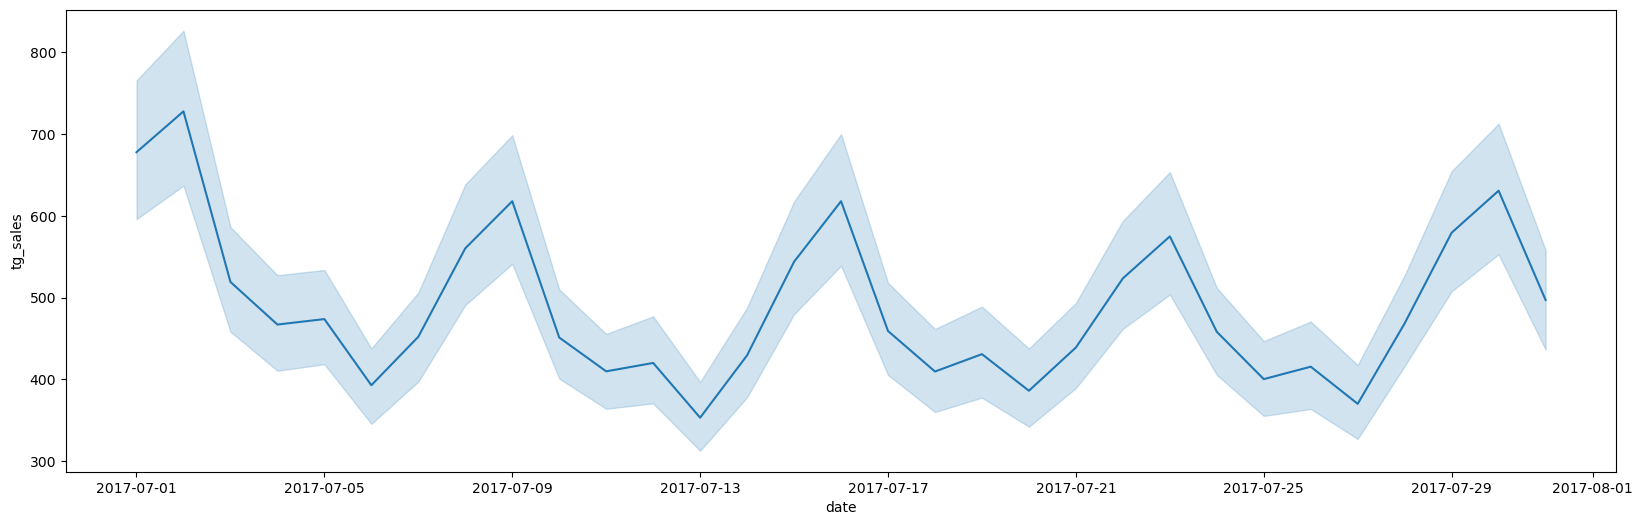

In [185]:
plt.figure(figsize = (20, 6))
sns.lineplot(data=df_teste, x="date", y="tg_sales")
plt.show()

In [200]:
df_predicao = pd.Series(modelo.predict(X_test), index=X_test.index, name='pd_sales')
df_predicao = pd.concat((X_test, df_predicao), axis=1)
df_predicao.head()

,ft_store,ft_onpromotion,ft_ano,ft_mes,ft_family,pd_sales
2918916,1,0,2017,7,0,-95.915519
2918917,1,0,2017,7,1,-101.762588
2918918,1,1,2017,7,2,-100.616783
2918919,1,27,2017,7,3,3017.006217
2918920,1,0,2017,7,4,-61.778926


In [201]:
df_concat = pd.merge(df_teste, df_predicao, left_index=True, right_index=True)

In [202]:
df_concat.head()

,id,date,ft_store_x,family,tg_sales,ft_onpromotion_x,ft_ano_x,ft_mes_x,trimestre,yyyy_mm,ft_family_x,trimestre_id,ft_store_y,ft_onpromotion_y,ft_ano_y,ft_mes_y,ft_family_y,pd_sales
2918916,2918916,2017-07-01,1,AUTOMOTIVE,7.0,0,2017,7,2017Q3,2017-7,0,18,1,0,2017,7,0,-95.915519
2918917,2918917,2017-07-01,1,BABY CARE,0.0,0,2017,7,2017Q3,2017-7,1,18,1,0,2017,7,1,-101.762588
2918918,2918918,2017-07-01,1,BEAUTY,7.0,1,2017,7,2017Q3,2017-7,2,18,1,1,2017,7,2,-100.616783
2918919,2918919,2017-07-01,1,BEVERAGES,2596.0,27,2017,7,2017Q3,2017-7,3,18,1,27,2017,7,3,3017.006217
2918920,2918920,2017-07-01,1,BOOKS,0.0,0,2017,7,2017Q3,2017-7,4,18,1,0,2017,7,4,-61.778926


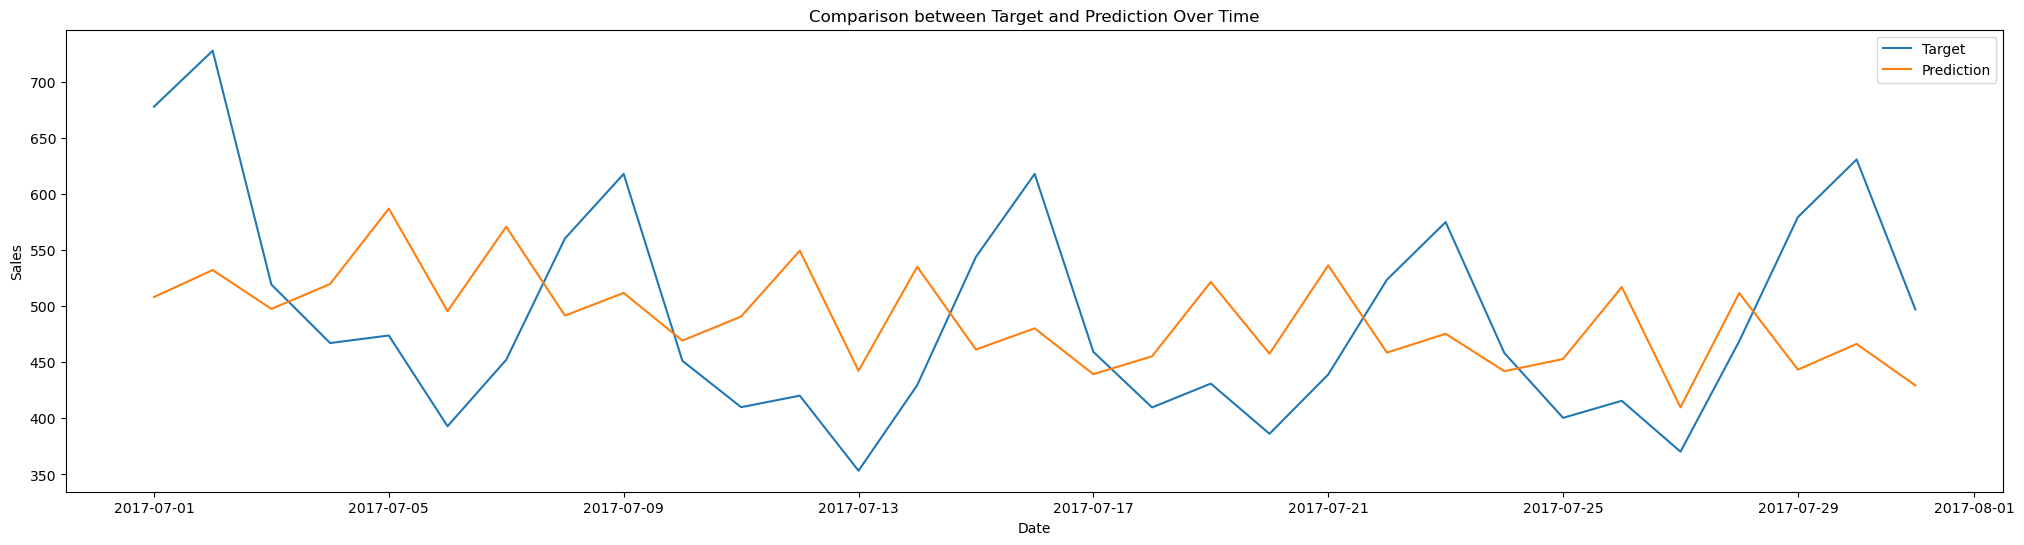

In [214]:
plt.figure(figsize=(25, 6))
sns.lineplot(data=df_concat, x='date', y='tg_sales', label='Target', ci=None)
sns.lineplot(data=df_concat, x='date', y='pd_sales', label='Prediction', ci=None)
plt.title('Comparison between Target and Prediction Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [156]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Cálculo das métricas
r2 = r2_score(y_test, ranked_predictions)
rmse = mean_squared_error(y_test, ranked_predictions, squared=False)
mae = mean_absolute_error(y_test, ranked_predictions)

# Impressão dos resultados
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R²: -0.1302
RMSE: 1437.9357
MAE: 488.5425


In [10]:
# Anwar
# modelo.predict(X_test)

In [11]:
# Anwar
# pd.concat((X_test, pd.Series(modelo.predict(X_test), index = X_test.index)), axis=1)

# Holdout 50/50

In [12]:
df_tv['trimestre'].unique()

<PeriodArray>
['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
 '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
 '2016Q3', '2016Q4', '2017Q1', '2017Q2']
Length: 18, dtype: period[Q-DEC]

In [13]:
# São 18 trimestre, sendo 50% = 9
df_treino = df_tv[df_tv['trimestre'] <= '2015Q1']
df_validacao = df_tv[df_tv['trimestre'] > '2015Q1']
print('Treino:', df_treino.shape, df_treino['trimestre'].unique())
print('Validação:', df_validacao.shape, df_validacao['trimestre'].unique())

Treino: (1457676, 12) <PeriodArray>
['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
 '2014Q4', '2015Q1']
Length: 9, dtype: period[Q-DEC]
Validação: (1461240, 12) <PeriodArray>
['2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2', '2016Q3', '2016Q4',
 '2017Q1', '2017Q2']
Length: 9, dtype: period[Q-DEC]


In [14]:
X_train = df_treino.filter(regex = r'ft_')
X_val = df_validacao.filter(regex = r'ft_')
y_train = df_treino['tg_sales']
y_val = df_validacao['tg_sales'] 

In [15]:
%%time

modelo = LGBMRegressor( max_depth = 5, 
                        num_leaves = 32, 
                        verbose = -1, 
                        learning_rate = 0.01, 
                        n_estimators = 1000, 
                        colsample_bytree = 0.1, 
                        random_state = 0)
modelo.fit(X_train, y_train)

CPU times: user 34.4 s, sys: 6.84 s, total: 41.2 s
Wall time: 9.88 s


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=1000, num_leaves=32, random_state=0, verbose=-1)

In [16]:
predictions = pd.Series(modelo.predict(X_val))

ranked_predictions = predictions.rank(pct = True, method = 'first')
correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
holdout_50_50 = correlation

In [17]:
holdout_50_50 = []
holdout_50_50.append('Validação: Holdout 50/50')
holdout_50_50.append(f'Média: {np.mean(correlation)}')
holdout_50_50.append(f'Median: {np.median(correlation)}')
holdout_50_50.append(f'Máximo: {np.max(correlation)}')
holdout_50_50.append(f'Mínimo: {np.min(correlation)}')
holdout_50_50.append(f'Desvio Padrão: {np.std(correlation)}')

# Holdout 70/30

df_tv['trimestre'].unique()

In [18]:
# São 18 trimestre, sendo 70% = 12,6 
df_treino = df_tv[df_tv['trimestre'] <= '2016Q1']
df_validacao = df_tv[df_tv['trimestre'] > '2016Q1']
print('Treino:', df_treino.shape, df_treino['trimestre'].unique())
print('Validação:', df_validacao.shape, df_validacao['trimestre'].unique())

Treino: (2108106, 12) <PeriodArray>
['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3',
 '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1']
Length: 13, dtype: period[Q-DEC]
Validação: (810810, 12) <PeriodArray>
['2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2']
Length: 5, dtype: period[Q-DEC]


In [19]:
X_train = df_treino.filter(regex = r'ft_')
X_val = df_validacao.filter(regex = r'ft_')
y_train = df_treino['tg_sales']
y_val = df_validacao['tg_sales'] 

In [20]:
%%time

modelo = LGBMRegressor( max_depth = 5, 
                        num_leaves = 32, 
                        verbose = -1, 
                        learning_rate = 0.01, 
                        n_estimators = 1000, 
                        colsample_bytree = 0.1, 
                        random_state = 0)
modelo.fit(X_train, y_train)

CPU times: user 1min, sys: 9.03 s, total: 1min 9s
Wall time: 18.2 s


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=1000, num_leaves=32, random_state=0, verbose=-1)

In [21]:
predictions = pd.Series(modelo.predict(X_val))

ranked_predictions = predictions.rank(pct = True, method = 'first')
correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]

In [44]:
holdout_70_30 = []
holdout_70_30.append('Validação: Holdout 70/30')
holdout_70_30.append(f'Média: {np.mean(correlation)}')
holdout_70_30.append(f'Median: {np.median(correlation)}')
holdout_70_30.append(f'Máximo: {np.max(correlation)}')
holdout_70_30.append(f'Mínimo: {np.min(correlation)}')
holdout_70_30.append(f'Desvio Padrão: {np.std(correlation)}')

# Holdout 60/10

In [23]:
df_tv['trimestre_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [24]:
# São 18 trimestre, sendo 60% = 10,8, 10% = 1,8 e 90% = 16,2
limite_60 = 11
limite_90 = 16
limite_10 = 2

In [25]:
resultado_val = []

for seed in range(20):
    np.random.seed(seed)
    split_point = np.random.randint(limite_60, limite_90)
    print(f"Repetition {seed} - Split point {split_point}")

    treino = df_tv[(df_tv['trimestre_id'] > split_point - limite_60) & (df_tv['trimestre_id'] <= split_point)]
    val = df_tv[(df_tv['trimestre_id'] > split_point) & (df_tv['trimestre_id'] <= split_point + limite_10)]

    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(max_depth = 5, num_leaves = 32, verbose = -1, learning_rate = 0.01, n_estimators = 1000, colsample_bytree = 0.1, random_state = 0)
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Repetition 0 - Split point 15
Correlation: 0.4880

Repetition 1 - Split point 14
Correlation: 0.4790

Repetition 2 - Split point 11
Correlation: 0.4514

Repetition 3 - Split point 13
Correlation: 0.4784

Repetition 4 - Split point 13
Correlation: 0.4784

Repetition 5 - Split point 14
Correlation: 0.4790

Repetition 6 - Split point 13
Correlation: 0.4784

Repetition 7 - Split point 15
Correlation: 0.4880

Repetition 8 - Split point 14
Correlation: 0.4790

Repetition 9 - Split point 15
Correlation: 0.4880

Repetition 10 - Split point 12
Correlation: 0.4623

Repetition 11 - Split point 12
Correlation: 0.4623

Repetition 12 - Split point 14
Correlation: 0.4790

Repetition 13 - Split point 13
Correlation: 0.4784

Repetition 14 - Split point 14
Correlation: 0.4790

Repetition 15 - Split point 11
Correlation: 0.4514

Repetition 16 - Split point 12
Correlation: 0.4623

Repetition 17 - Split point 12
Correlation: 0.4623

Repetition 18 - Split point 13
Correlation: 0.4784

Repetition 19 - Split 

In [43]:
holdout_60_10 = []
holdout_60_10.append('Validação: Holdout 60/10')
holdout_60_10.append(f'Média: {np.mean(resultado_val)}')
holdout_60_10.append(f'Median: {np.median(resultado_val)}')
holdout_60_10.append(f'Máximo: {np.max(resultado_val)}')
holdout_60_10.append(f'Mínimo: {np.min(resultado_val)}')
holdout_60_10.append(f'Desvio Padrão: {np.std(resultado_val)}')

# Prequential Expanding

In [27]:
resultado_val = []

for iteration in range(1, 18):
    print(f"Iteration {iteration}")
    print(f"Train blocks: 0-{iteration - 1}")
    print(f"Validation block: {iteration}")

    treino = df_tv[df_tv['trimestre_id'] < iteration ]
    val = df_tv[df_tv['trimestre_id'] == iteration]
  
    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(
        max_depth = 5, 
        num_leaves = 32, 
        verbose = -1, 
        learning_rate = 0.01,
        n_estimators = 1000, 
        colsample_bytree = 0.1, 
        random_state = 0 )
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Iteration 1
Train blocks: 0-0
Validation block: 1
Correlation: 0.4292

Iteration 2
Train blocks: 0-1
Validation block: 2
Correlation: 0.4322

Iteration 3
Train blocks: 0-2
Validation block: 3
Correlation: 0.4188

Iteration 4
Train blocks: 0-3
Validation block: 4
Correlation: 0.4080

Iteration 5
Train blocks: 0-4
Validation block: 5
Correlation: 0.4339

Iteration 6
Train blocks: 0-5
Validation block: 6
Correlation: 0.4380

Iteration 7
Train blocks: 0-6
Validation block: 7
Correlation: 0.4457

Iteration 8
Train blocks: 0-7
Validation block: 8
Correlation: 0.4398

Iteration 9
Train blocks: 0-8
Validation block: 9
Correlation: 0.4519

Iteration 10
Train blocks: 0-9
Validation block: 10
Correlation: 0.4712

Iteration 11
Train blocks: 0-10
Validation block: 11
Correlation: 0.4640

Iteration 12
Train blocks: 0-11
Validation block: 12
Correlation: 0.4696

Iteration 13
Train blocks: 0-12
Validation block: 13
Correlation: 0.4415

Iteration 14
Train blocks: 0-13
Validation block: 14
Correlation: 

In [28]:
prequential_expanding = []
prequential_expanding.append('Validação: Prequential Expanding')
prequential_expanding.append(f'Média: {np.mean(resultado_val)}')
prequential_expanding.append(f'Median: {np.median(resultado_val)}')
prequential_expanding.append(f'Máximo: {np.max(resultado_val)}')
prequential_expanding.append(f'Mínimo: {np.min(resultado_val)}')
prequential_expanding.append(f'Desvio Padrão: {np.std(resultado_val)}')

# Prequential Expanding with gap

In [29]:
resultado_val = []

for iteration in range(1, 17):
    print(f"Iteration {iteration}")
    print(f"Train blocks: 0-{iteration - 1}")
    print(f"Validation block: {iteration}")

    treino = df_tv[df_tv['trimestre_id'] < iteration ]
    val = df_tv[df_tv['trimestre_id']  == iteration + 1]
  
    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(
        max_depth = 5, 
        num_leaves = 32, 
        verbose = -1, 
        learning_rate = 0.01,
        n_estimators = 1000, 
        colsample_bytree = 0.1, 
        random_state = 0 )
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Iteration 1
Train blocks: 0-0
Validation block: 1
Correlation: 0.4314

Iteration 2
Train blocks: 0-1
Validation block: 2
Correlation: 0.4185

Iteration 3
Train blocks: 0-2
Validation block: 3
Correlation: 0.4073

Iteration 4
Train blocks: 0-3
Validation block: 4
Correlation: 0.4375

Iteration 5
Train blocks: 0-4
Validation block: 5
Correlation: 0.4410

Iteration 6
Train blocks: 0-5
Validation block: 6
Correlation: 0.4345

Iteration 7
Train blocks: 0-6
Validation block: 7
Correlation: 0.4431

Iteration 8
Train blocks: 0-7
Validation block: 8
Correlation: 0.4522

Iteration 9
Train blocks: 0-8
Validation block: 9
Correlation: 0.4705

Iteration 10
Train blocks: 0-9
Validation block: 10
Correlation: 0.4601

Iteration 11
Train blocks: 0-10
Validation block: 11
Correlation: 0.4671

Iteration 12
Train blocks: 0-11
Validation block: 12
Correlation: 0.4378

Iteration 13
Train blocks: 0-12
Validation block: 13
Correlation: 0.4851

Iteration 14
Train blocks: 0-13
Validation block: 14
Correlation: 

In [30]:
prequential_expanding_gap = []
prequential_expanding_gap.append('Validação: Prequential Expanding with Gap')
prequential_expanding_gap.append(f'Média: {np.mean(resultado_val)}')
prequential_expanding_gap.append(f'Median: {np.median(resultado_val)}')
prequential_expanding_gap.append(f'Máximo: {np.max(resultado_val)}')
prequential_expanding_gap.append(f'Mínimo: {np.min(resultado_val)}')
prequential_expanding_gap.append(f'Desvio Padrão: {np.std(resultado_val)}')

# Prequential Sliding

In [31]:
resultado_val = []

for iteration in range(1, 18):
    print(f"Iteration {iteration}")
    print(f"Train blocks: 0-{iteration - 1}")
    print(f"Validation block: {iteration}")

    treino = df_tv[df_tv['trimestre_id'] == iteration - 1]
    val = df_tv[df_tv['trimestre_id'] == iteration]
  
    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(
        max_depth = 5, 
        num_leaves = 32, 
        verbose = -1, 
        learning_rate = 0.01,
        n_estimators = 1000, 
        colsample_bytree = 0.1, 
        random_state = 0 )
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Iteration 1
Train blocks: 0-0
Validation block: 1
Correlation: 0.4292

Iteration 2
Train blocks: 0-1
Validation block: 2
Correlation: 0.4326

Iteration 3
Train blocks: 0-2
Validation block: 3
Correlation: 0.4192

Iteration 4
Train blocks: 0-3
Validation block: 4
Correlation: 0.4079

Iteration 5
Train blocks: 0-4
Validation block: 5
Correlation: 0.4186

Iteration 6
Train blocks: 0-5
Validation block: 6
Correlation: 0.4188

Iteration 7
Train blocks: 0-6
Validation block: 7
Correlation: 0.4558

Iteration 8
Train blocks: 0-7
Validation block: 8
Correlation: 0.4198

Iteration 9
Train blocks: 0-8
Validation block: 9
Correlation: 0.4409

Iteration 10
Train blocks: 0-9
Validation block: 10
Correlation: 0.4737

Iteration 11
Train blocks: 0-10
Validation block: 11
Correlation: 0.4680

Iteration 12
Train blocks: 0-11
Validation block: 12
Correlation: 0.4772

Iteration 13
Train blocks: 0-12
Validation block: 13
Correlation: 0.4529

Iteration 14
Train blocks: 0-13
Validation block: 14
Correlation: 

In [32]:
prequential_sliding = []
prequential_sliding.append('Validação: Prequential Sliding')
prequential_sliding.append(f'Média: {np.mean(resultado_val)}')
prequential_sliding.append(f'Median: {np.median(resultado_val)}')
prequential_sliding.append(f'Máximo: {np.max(resultado_val)}')
prequential_sliding.append(f'Mínimo: {np.min(resultado_val)}')
prequential_sliding.append(f'Desvio Padrão: {np.std(resultado_val)}')

# Prequential Sliding with gap

In [33]:
resultado_val = []

for iteration in range(1, 17):
    print(f"Iteration {iteration}")
    print(f"Train blocks: 0-{iteration - 1}")
    print(f"Validation block: {iteration}")

    treino = df_tv[df_tv['trimestre_id'] == iteration - 1]
    val = df_tv[df_tv['trimestre_id'] == iteration + 1]
  
    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(
        max_depth = 5, 
        num_leaves = 32, 
        verbose = -1, 
        learning_rate = 0.01,
        n_estimators = 1000, 
        colsample_bytree = 0.1, 
        random_state = 0 )
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Iteration 1
Train blocks: 0-0
Validation block: 1
Correlation: 0.4314

Iteration 2
Train blocks: 0-1
Validation block: 2
Correlation: 0.4189

Iteration 3
Train blocks: 0-2
Validation block: 3
Correlation: 0.4074

Iteration 4
Train blocks: 0-3
Validation block: 4
Correlation: 0.4377

Iteration 5
Train blocks: 0-4
Validation block: 5
Correlation: 0.4521

Iteration 6
Train blocks: 0-5
Validation block: 6
Correlation: 0.4108

Iteration 7
Train blocks: 0-6
Validation block: 7
Correlation: 0.4283

Iteration 8
Train blocks: 0-7
Validation block: 8
Correlation: 0.4430

Iteration 9
Train blocks: 0-8
Validation block: 9
Correlation: 0.4269

Iteration 10
Train blocks: 0-9
Validation block: 10
Correlation: 0.4589

Iteration 11
Train blocks: 0-10
Validation block: 11
Correlation: 0.4769

Iteration 12
Train blocks: 0-11
Validation block: 12
Correlation: 0.4497

Iteration 13
Train blocks: 0-12
Validation block: 13
Correlation: 0.4958

Iteration 14
Train blocks: 0-13
Validation block: 14
Correlation: 

In [34]:
prequential_sliding_gap = []
prequential_sliding_gap.append('Validação: Prequential Sliding with Gap')
prequential_sliding_gap.append(f'Média: {np.mean(resultado_val)}')
prequential_sliding_gap.append(f'Median: {np.median(resultado_val)}')
prequential_sliding_gap.append(f'Máximo: {np.max(resultado_val)}')
prequential_sliding_gap.append(f'Mínimo: {np.min(resultado_val)}')
prequential_sliding_gap.append(f'Desvio Padrão: {np.std(resultado_val)}')

# Cross Validation

In [35]:
resultado_val = []

for iteration in range(1, 18):
    print(f"Iteration {iteration}")
    print(f"Train blocks: 0-{iteration - 1}")
    print(f"Validation block: {iteration}")

    treino = df_tv[df_tv['trimestre_id'] != iteration]
    val = df_tv[df_tv['trimestre_id'] == iteration]
  
    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(
        max_depth = 5, 
        num_leaves = 32, 
        verbose = -1, 
        learning_rate = 0.01,
        n_estimators = 1000, 
        colsample_bytree = 0.1, 
        random_state = 0 )
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Iteration 1
Train blocks: 0-0
Validation block: 1
Correlation: 0.3961

Iteration 2
Train blocks: 0-1
Validation block: 2
Correlation: 0.3994

Iteration 3
Train blocks: 0-2
Validation block: 3
Correlation: 0.3874

Iteration 4
Train blocks: 0-3
Validation block: 4
Correlation: 0.4344

Iteration 5
Train blocks: 0-4
Validation block: 5
Correlation: 0.4058

Iteration 6
Train blocks: 0-5
Validation block: 6
Correlation: 0.4453

Iteration 7
Train blocks: 0-6
Validation block: 7
Correlation: 0.4529

Iteration 8
Train blocks: 0-7
Validation block: 8
Correlation: 0.4240

Iteration 9
Train blocks: 0-8
Validation block: 9
Correlation: 0.4458

Iteration 10
Train blocks: 0-9
Validation block: 10
Correlation: 0.4788

Iteration 11
Train blocks: 0-10
Validation block: 11
Correlation: 0.4668

Iteration 12
Train blocks: 0-11
Validation block: 12
Correlation: 0.4740

Iteration 13
Train blocks: 0-12
Validation block: 13
Correlation: 0.4499

Iteration 14
Train blocks: 0-13
Validation block: 14
Correlation: 

In [36]:
cross_validation = []
cross_validation.append('Validação: Cross Validation')
cross_validation.append(f'Média: {np.mean(resultado_val)}')
cross_validation.append(f'Median: {np.median(resultado_val)}')
cross_validation.append(f'Máximo: {np.max(resultado_val)}')
cross_validation.append(f'Mínimo: {np.min(resultado_val)}')
cross_validation.append(f'Desvio Padrão: {np.std(resultado_val)}')

# Cross Validation with gap

In [37]:
resultado_val = []

for iteration in range(0, 18):
    print(f"Iteration {iteration + 1}")
    
    if iteration == 0:
        train_blocks = list(range(2, 13))
    elif iteration == 12:
        train_blocks = list(range(0, 11))
    else:
        train_blocks = [block for block in range(0, 13) if block != iteration and (block < iteration - 1 or block > iteration + 1)] 
    
    print(f"Train blocks: {train_blocks}")
    print(f"Validation block: {iteration}")

    treino = df_tv[df_tv['trimestre_id'].isin(train_blocks)]
    val = df_tv[df_tv['trimestre_id'] == iteration]

    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(
        max_depth = 5, 
        num_leaves = 32, 
        verbose = -1, 
        learning_rate = 0.01,
        n_estimators = 1000, 
        colsample_bytree = 0.1, 
        random_state = 0 )
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Iteration 1
Train blocks: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Validation block: 0
Correlation: 0.3963

Iteration 2
Train blocks: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Validation block: 1
Correlation: 0.4008

Iteration 3
Train blocks: [0, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Validation block: 2
Correlation: 0.4027

Iteration 4
Train blocks: [0, 1, 5, 6, 7, 8, 9, 10, 11, 12]
Validation block: 3
Correlation: 0.3921

Iteration 5
Train blocks: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12]
Validation block: 4
Correlation: 0.4388

Iteration 6
Train blocks: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]
Validation block: 5
Correlation: 0.4126

Iteration 7
Train blocks: [0, 1, 2, 3, 4, 8, 9, 10, 11, 12]
Validation block: 6
Correlation: 0.4490

Iteration 8
Train blocks: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12]
Validation block: 7
Correlation: 0.4549

Iteration 9
Train blocks: [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]
Validation block: 8
Correlation: 0.4344

Iteration 10
Train blocks: [0, 1, 2, 3, 4, 5, 6, 7, 11, 12]
Validation block: 9
Correlat

In [38]:
cross_validation_gap = []
cross_validation_gap.append('Validação: Cross Validation with Gap')
cross_validation_gap.append(f'Média: {np.mean(resultado_val)}')
cross_validation_gap.append(f'Median: {np.median(resultado_val)}')
cross_validation_gap.append(f'Máximo: {np.max(resultado_val)}')
cross_validation_gap.append(f'Mínimo: {np.min(resultado_val)}')
cross_validation_gap.append(f'Desvio Padrão: {np.std(resultado_val)}')

# Combinatorial Purged Cross Validation

In [39]:
from itertools import permutations
permutacoes = permutations(range(0, 18), 2)
permutacoes_purged = [permutacao for permutacao in permutacoes if abs(permutacao[0] - permutacao[1]) != 1]
resultado_val = []

cont = 1
for permutacao in permutacoes_purged:
    print(f"Iteration {cont}")
    cont += 1

    print(f"Train block: {permutacao[0]}")
    print(f"Validation block: {permutacao[1]}")

    treino = df_tv[df_tv['trimestre_id'] == permutacao[0]]
    val = df_tv[df_tv['trimestre_id'] == permutacao[1]]

    X_train = treino.filter(regex = r'ft_')
    X_val = val.filter(regex = r'ft_')
    y_train = treino['tg_sales']
    y_val = val['tg_sales']  

    modelo = LGBMRegressor(
        max_depth = 5, 
        num_leaves = 32, 
        verbose = -1, 
        learning_rate = 0.01,
        n_estimators = 1000, 
        colsample_bytree = 0.1, 
        random_state = 0 )
    modelo.fit(X_train, y_train)

    predictions = pd.Series(modelo.predict(X_val))
    ranked_predictions = predictions.rank(pct = True, method = 'first')
    correlation = np.corrcoef(y_val, ranked_predictions)[0, 1]
    resultado_val.append(correlation)

    print(f'Correlation: {correlation:.4f}\n')

Iteration 1
Train block: 0
Validation block: 2


Correlation: 0.4314

Iteration 2
Train block: 0
Validation block: 3
Correlation: 0.4175

Iteration 3
Train block: 0
Validation block: 4
Correlation: 0.4063

Iteration 4
Train block: 0
Validation block: 5
Correlation: 0.4350

Iteration 5
Train block: 0
Validation block: 6
Correlation: 0.4111

Iteration 6
Train block: 0
Validation block: 7
Correlation: 0.4007

Iteration 7
Train block: 0
Validation block: 8
Correlation: 0.4480

Iteration 8
Train block: 0
Validation block: 9
Correlation: 0.4331

Iteration 9
Train block: 0
Validation block: 10
Correlation: 0.4176

Iteration 10
Train block: 0
Validation block: 11
Correlation: 0.4087

Iteration 11
Train block: 0
Validation block: 12
Correlation: 0.4102

Iteration 12
Train block: 0
Validation block: 13
Correlation: 0.3867

Iteration 13
Train block: 0
Validation block: 14
Correlation: 0.4178

Iteration 14
Train block: 0
Validation block: 15
Correlation: 0.4019

Iteration 15
Train block: 0
Validation block: 16
Correlation: 0.4084

Iteration 16
T

In [40]:
combinatorial_purged = []
combinatorial_purged.append('Validação: Combinatorial Purged')
combinatorial_purged.append(f'Média: {np.mean(resultado_val)}')
combinatorial_purged.append(f'Median: {np.median(resultado_val)}')
combinatorial_purged.append(f'Máximo: {np.max(resultado_val)}')
combinatorial_purged.append(f'Mínimo: {np.min(resultado_val)}')
combinatorial_purged.append(f'Desvio Padrão: {np.std(resultado_val)}')

# Análise dos resultados

In [58]:
print("Valor do df de TESTE:", valor_teste_prd)

Valor do df de TESTE: 0.4970055582986661


In [96]:
# Lista com os resultados de todas as validações
resultados = [
    holdout_50_50,
    holdout_70_30,
    holdout_60_10,
    prequential_expanding,
    prequential_expanding_gap,
    prequential_sliding,
    prequential_sliding_gap,
    cross_validation,
    cross_validation_gap,
    combinatorial_purged
]

In [91]:
colunas_nome = ['validação', 'media', 'mediana', 'maximo', 'minimo', 'desvio_padrao']

col_validacao = []
col_media = []
col_mediana = []
col_max = []
col_min = []
col_dp = []

for lista in resultados:
    col_validacao.append(lista[0].split(': ')[1])
    col_media.append(lista[1].split(': ')[1])
    col_mediana.append(lista[2].split(': ')[1])
    col_max.append(lista[3].split(': ')[1])
    col_min.append(lista[4].split(': ')[1])
    col_dp.append(lista[5].split(': ')[1])

In [92]:
colunas = [col_validacao, col_media, col_mediana, col_max, col_min, col_dp]
colunas_pivot = list(map(list, zip(*colunas)))

In [98]:
df_resultado = pd.DataFrame(colunas_pivot[0:], columns=colunas_nome)

In [101]:
colunas_numericas = ['media', 'mediana', 'maximo', 'minimo', 'desvio_padrao']

# Itera sobre as colunas que você deseja transformar
for column in colunas_numericas:
    # Transforma a coluna em número se possível
    df_resultado[column] = pd.to_numeric(df_resultado[column], errors='coerce')

In [124]:
print(valor_teste_prd)

0.4970055582986661


In [112]:
df_resultado.head(10)

,validação,media,mediana,maximo,minimo,desvio_padrao,dif,valida_prd
0,Holdout 50/50,0.450075,0.450075,0.450075,0.450075,0.000000,-0.046930,N
1,Holdout 70/30,0.465076,0.465076,0.465076,0.465076,0.000000,-0.031929,N
2,Holdout 60/10,0.428705,0.425497,0.495811,0.369336,0.031799,-0.071508,N
3,Prequential Expanding,0.451765,0.445659,0.490858,0.408006,0.024185,-0.051347,N
4,Prequential Expanding with Gap,0.451845,0.447641,0.488576,0.407327,0.023670,-0.049364,N
5,Prequential Sliding,0.449567,0.452871,0.492488,0.407926,0.027104,-0.044135,N
6,Prequential Sliding with Gap,0.448665,0.446373,0.495811,0.407441,0.027059,-0.050632,N
7,Cross Validation,0.447088,0.449892,0.494465,0.387395,0.033468,-0.047113,N
8,Cross Validation with Gap,0.443413,0.450618,0.485115,0.392131,0.030023,-0.046387,N
9,Combinatorial Purged,0.428705,0.425497,0.495811,0.369336,0.031799,-0.071508,N


In [109]:
df_resultado['dif'] = df_resultado['mediana'] - valor_teste_prd

In [111]:
df_resultado['valida_prd'] = df_resultado.apply(lambda row: 'S' if valor_teste_prd >= row['minimo'] and valor_teste_prd <= row['maximo'] else 'N', axis=1)
